In [30]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ParseData
import scipy.stats as stats
import numpy as np

import importlib
importlib.reload(ParseData)

%matplotlib notebook

Data = ParseData.GetData()

Total Police Killings in Canada: Jan 2000 - June 2020: 590
Missing Recrods in CBC data:  12
Incidetns since CBC data published:  22
LinregressResult(slope=1.090909090909091, intercept=-2164.822510822511, rvalue=0.793926263171813, pvalue=1.737738560697388e-05, stderr=0.19166605717780766)


<IPython.core.display.Javascript object>


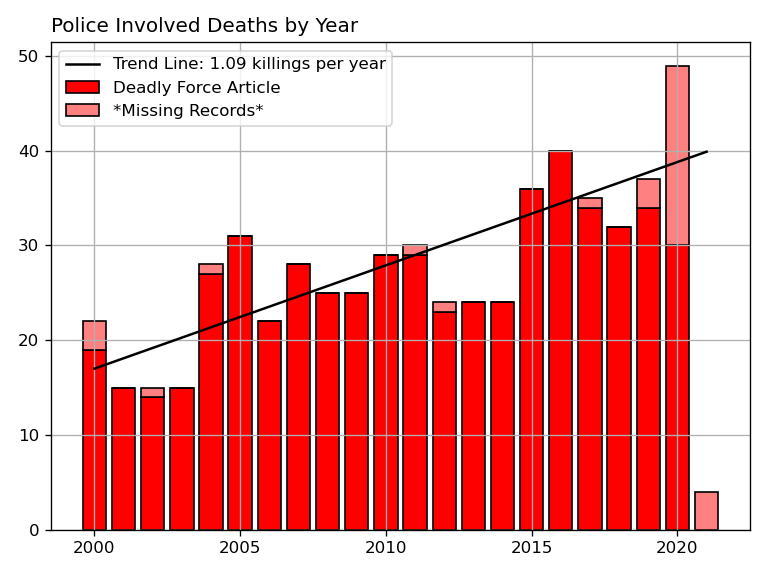

In [31]:
CA_Total=Data.CA_PoliceKillings['PROV'].count()
print('Total Police Killings in Canada: Jan 2000 - June 2020: '+str(CA_Total.sum()))
ByYear=Data.CA_PoliceKillings.resample('YS').count()['PROV']

MonthlyMiss = Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['DATA SOURCE']=='Other'].resample('MS').count()['PROV']
print('Missing Recrods in CBC data: ',MonthlyMiss.loc[MonthlyMiss.index<'2020-07-01'].sum())

print('Incidetns since CBC data published: ',MonthlyMiss.loc[MonthlyMiss.index>='2020-07-01'].sum())


CBC_Article = Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['DATA SOURCE']=='CBC Deadly Force'].resample('YS').count()['PROV']
Missing = Data.CA_PoliceKillings.loc[Data.CA_PoliceKillings['DATA SOURCE']=='Other'].resample('YS').count()['PROV']


LR = stats.linregress(ByYear.index.year[:-1],ByYear.values[:-1])
print(LR)


fig,ax=plt.subplots(1,1)
ax.set_title('Police Involved Deaths by Year',loc='left')
ax.bar(CBC_Article.index.year,CBC_Article.values,
       color=[1,0,0],edgecolor='k',label='Deadly Force Article')
ax.bar(Missing.index.year,Missing.values,bottom = np.append(CBC_Article.values,[0]),
       color=[1,0.5,0.5],edgecolor='k',label='*Missing Records*')
# ax.bar([2020],[ByYear.values[-1]],color=[1,.5,.5],edgecolor='k',label='Total Jan-Nov')
ax.plot(ByYear.index.year,ByYear.index.year*LR[0]+LR[1],
        color='k',label = 'Trend Line: '+str(np.round(LR[0],2))+' killings per year')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('Content/CA_Trendline.png')

In [32]:
ByRace = (Data.CA_PoliceKillings.groupby('RACE').count()['PROV'])
print(ByRace['Unknown']/ByRace.sum())

0.26101694915254237


<IPython.core.display.Javascript object>


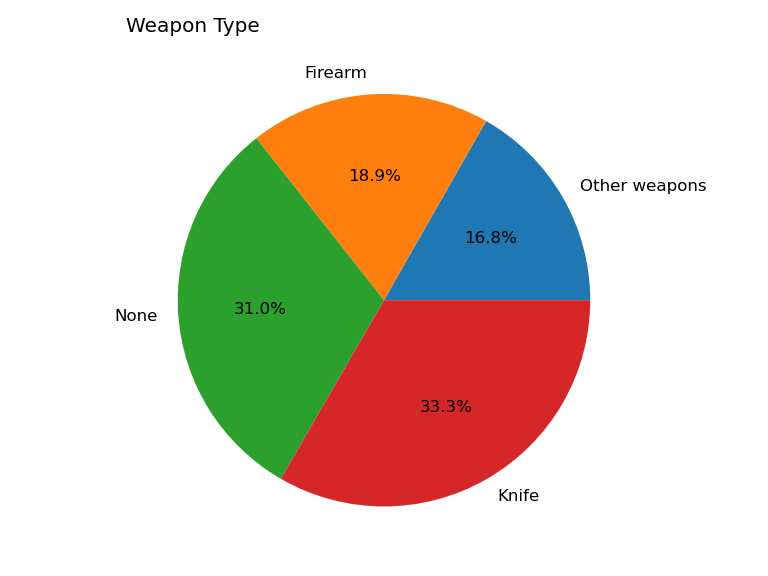

In [29]:
Weaopn_Type=Data.CA_PoliceKillings.groupby('ARMED TYPE').count()['AGE'].sort_values()

fig,ax=plt.subplots(1,1)
ax.set_title('Weapon Type',loc='left')
ax.pie(Weaopn_Type.values,labels=Weaopn_Type.index,
    autopct='%1.1f%%')
plt.tight_layout()
plt.savefig('Content/CA_Weapon.png')

<IPython.core.display.Javascript object>


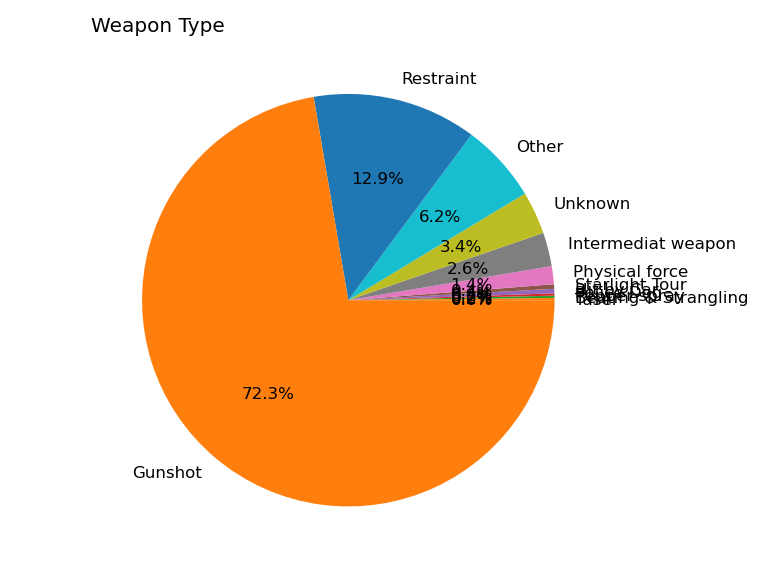

In [33]:
Weaopn_Type=Data.CA_PoliceKillings.groupby('CAUSE DEATH').count()['AGE'].sort_values()

fig,ax=plt.subplots(1,1)
ax.set_title('Weapon Type',loc='left')
ax.pie(Weaopn_Type.values,labels=Weaopn_Type.index,
    autopct='%1.1f%%')
plt.tight_layout()
plt.savefig('Content/CA_Weapon.png')

https://bccla.org/wp-content/uploads/2012/03/2012-BCCLA-Report-Police-Involved-Deaths3.pdf